In [86]:
import pandas as pd
import numpy as np

hit3 = pd.read_csv('hit_3_output.csv')

qlist = []
parties = []
for col in range(27,97,5):
    x = hit3.columns[col]
    topic = x[x.find(".")+1:x.rfind(".")]
    qlist.append(topic)
for col in range(100,145,5):
    x = hit3.columns[col]
    topic = x[x.find(".")+1:x.rfind(".")]
    qlist.append(topic)
for col in range(97,100):
    x = hit3.columns[col]
    party = x[x.rfind(".")+1:]
    parties.append(party)

In [82]:
hit3.columns[27:97:5]
hit3.columns[97:100]
#hit3.columns[100:145:5]

Index(['Answer.party.democrat', 'Answer.party.independent',
       'Answer.party.republican'],
      dtype='object')

In [710]:
o1 = 0
o2 = 0
n12 = 0
b12 = 0
n = len(hit3)
for index, row in hit3.iterrows():
    person = {}
    y_exists = False
    if row['Answer.agree_test.agree'] and row['Answer.dis_test.disagree']:
        n12 += 1
    elif row['Answer.agree_test.agree'] and not row['Answer.dis_test.disagree']:
        o2 += 1   
    elif not row['Answer.agree_test.agree'] and row['Answer.dis_test.disagree']:
        o1 += 1    
    elif not row['Answer.agree_test.agree'] and not row['Answer.dis_test.disagree']:
        b12 += 1
o1 /= n
o2 /= n
b12 /= n
n12 /= n

In [746]:
print(b12)

0.046296296296296294


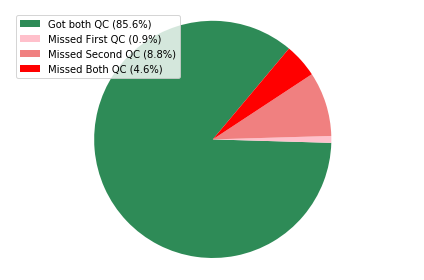

In [772]:
labels = 'Got both QC (85.6%)','Missed First QC (0.9%)', 'Missed Second QC (8.8%)', 'Missed Both QC (4.6%)'
colors = ['seagreen', 'pink', 'lightcoral', 'red']
patches, texts  = plt.pie([n12,o1,o2,b12],colors=colors, startangle=50)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [139]:
baddies = 0
non_answered = 0
miss= 0
people = []
scale = {'agree':1,'disagree':-1,'neither':0,'s_disagree':-2,'s_agree':2}
parties = {'democrat':-1,'independent':0,'republican':1}
for index, row in hit3.iterrows():
    person = {}
    y_exists = False
    if row['Answer.agree_test.agree'] and row['Answer.dis_test.disagree']:
        for topic in qlist:
            answered = False
            for ans in scale:
                res = row['Answer.'+str(topic)+"."+str(ans)]
                if res:
                    person[topic] = float(scale[ans])
                    answered = True
            if answered == False:
                non_answered += 1
                person[topic] = -100.
        for party in parties:
            res = row['Answer.party.'+party]
            if res:
                person['party'] = float(parties[party])
                y_exists = True
        if not y_exists:
            miss +=1
        if y_exists:
            people.append(person)
        else:
            pass
    else:
        baddies +=1
df = pd.DataFrame(people)

In [142]:
#averaging everyone who put no result
ncols = len(df.columns)
totals = [0]*ncols
ns = [0]*ncols
for index, row in df.iterrows():
    for col in range(ncols):
        if row[col] != -100:
            totals[col] += row[col]
            ns[col] += 1
avgs = [0]*ncols
desc = {}
for col in range(ncols):
    avgs[col] = totals[col] / ns[col]
    desc[df.columns[col]] = avgs[col]
    
#set -100s to the average    
for index, row in df.iterrows():
    for col in range(ncols):
        if row[col] == -100:
            row[col] = desc[df.columns[col]]

In [414]:
from sklearn.model_selection import train_test_split
ys = df['party']
xs = df[qlist]
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=0)

In [235]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
pred = reg.predict(X_test)
tpred = reg.predict(X_train)
print("Accuracy: " + str(np.sum(pred == y_test) / len(y_test)))
#reg.coef_

Accuracy: 0.3783783783783784


In [358]:
from sklearn.cluster import KMeans
import itertools

kmeans = KMeans(n_clusters=3, random_state=4).fit(X_train)
ky = kmeans.predict(X_test)
perm = list(itertools.permutations([-1, 0, 1]))

max_acc = -1
max_p = (0,0,0)
for p in perm:
    total = 0
    for i in range(len(kmeans.labels_)):
        val = p[int(kmeans.labels_[i])]
        if val == y_train.values[i]:
            total += 1           
    acc = total / len(kmeans.labels_)
    #print(acc)
    
    if acc > max_acc:
        max_p = p
        max_acc = acc
        
total = 0
for i in range(len(ky)):
    val = p[int(ky[i])]
    if val == y_test.values[i]:
        total += 1           
kmeans_acc = total / len(ky)
print("Kmeans accuracy: "+str(kmeans_acc))

Kmeans accuracy: 0.13513513513513514


In [365]:
nparties = {"Democrat":0, "Republican":0,"Independent":0}
for party in ys:
    if party == -1:
        nparties['Democrat'] += 1
    elif party == 1:
        nparties['Republican'] += 1
    elif party == 0:
        nparties['Independent'] += 1
    else:
        print("ERROR")
print (nparties)

{'Republican': 48, 'Independent': 63, 'Democrat': 74}


In [377]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, 1, step=1)
selector = selector.fit(X_train, y_train)
r = selector.ranking_

In [689]:
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=0)
n_states = 10
nd = 21
accuracies = [0] * nd
for state in range(n_states):
    for d in range(2,nd+2):
        Xs = X_train[list(np.nonzero((r<d) * 1)[0])]
        X_tr_cv, X_te_cv, y_tr_cv, y_te_cv = train_test_split(Xs, y_train, test_size=0.2, random_state=state)
        reg = LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(X_tr_cv, y_tr_cv)
        pred = reg.predict(X_te_cv)
        #print("Accuracy "+str(d-1)+" features:" + str(np.sum(pred == y_te_cv) / len(y_te_cv)))
        accuracies[d-2] += np.sum(pred == y_te_cv) / len(y_te_cv)

for i in range(nd):
    accuracies[i] /= n_states
bestd = np.argmax(accuracies)+2
Xs = X_train[list(np.nonzero((r<bestd) * 1)[0])]
reg = LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(Xs, y_train)
pred = reg.predict(X_test[list(np.nonzero((r<bestd) * 1)[0])])
print("CV accuracy: " + str(np.sum(pred == y_test) / len(y_test)))

CV accuracy: 0.43243243243243246


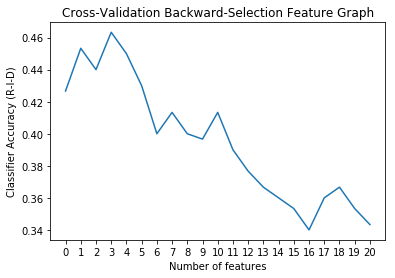

In [699]:
plt.plot(accuracies)
plt.xticks([i for i in range(0, nd)])
plt.xlabel("Number of features")
plt.ylabel("Classifier Accuracy (R-I-D)")
plt.title("Cross-Validation Backward-Selection Feature Graph")
plt.show()

In [492]:
opt = ['movies', 'music_n', 'read', 'religion', 'science', 'sports', 'tech', 'tv', 'vg']
X_train, X_test, y_train, y_test = train_test_split(xs[opt], ys, test_size=0.2, random_state=0)
reg = LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
pred = reg.predict(X_test)
tpred = reg.predict(X_train)
print("Accuracy handpicked features:" + str(np.sum(pred == y_test) / len(y_test)))

Accuracy handpicked features:0.5405405405405406


In [700]:
txs = X_train[list(np.nonzero((r<14) * 1)[0])]
import itertools
topics = []
for s in range(1,14):
    temp = itertools.combinations(txs, s)
    for top in temp:
        topics.append(list(top))

In [701]:
len(topics)

8191

In [592]:
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=99)
n_states = 1
accuracies = [0] * len(topics)
for state in range(n_states):
    for i in range(len(topics)):
        Xs = X_train[topics[i]]
        X_tr_cv, X_te_cv, y_tr_cv, y_te_cv = train_test_split(Xs, y_train, test_size=0.2, random_state=state)
        reg = LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(X_tr_cv, y_tr_cv)
        pred = reg.predict(X_te_cv)
        #print("Accuracy "+str(d-1)+" features:" + str(np.sum(pred == y_te_cv) / len(y_te_cv)))
        accuracies[i] += np.sum(pred == y_te_cv) / len(y_te_cv)
        
best_set = np.argmax(accuracies)
Xs = X_train[topics[best_set]]
print(topics[best_set])
reg = LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(Xs, y_train)
pred = reg.predict(X_test[topics[best_set]])
print("CV accuracy: " + str(np.sum(pred == y_test) / len(y_test)))

['gardening', 'hobby', 'science', 'sports']
CV accuracy: 0.35135135135135137


In [591]:
best_acc = 0
bstate = 0
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=i)
    Xs = X_train[topics[best_set]]
    reg = LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(Xs, y_train)
    pred = reg.predict(X_test[topics[best_set]])
    acc = np.sum(pred == y_test) / len(y_test)
    if acc > best_acc:
        bstate = i
        best_acc = acc
print(str(best_acc)+", "+str(i))

0.5675675675675675, 99


In [485]:
#KMEANS with handpicked features
X_train, X_test, y_train, y_test = train_test_split(xs[opt], ys, test_size=0.2, random_state=0)
kmeans = KMeans(n_clusters=3, random_state=4).fit(X_train)
ky = kmeans.predict(X_test)
perm = list(itertools.permutations([-1, 0, 1]))

max_acc = -1
max_p = (0,0,0)
for p in perm:
    total = 0
    for i in range(len(kmeans.labels_)):
        val = p[int(kmeans.labels_[i])]
        if val == y_train.values[i]:
            total += 1           
    acc = total / len(kmeans.labels_)
    
    if acc > max_acc:
        max_p = p
        max_acc = acc
        
total = 0
for i in range(len(ky)):
    val = p[int(ky[i])]
    if val == y_test.values[i]:
        total += 1           
kmeans_acc = total / len(ky)
print("Kmeans accuracy: "+str(kmeans_acc))

Kmeans accuracy: 0.2972972972972973


array(['agree_test', 'cooking', 'dis_test', 'education', 'finance', 'fit',
       'football', 'gardening', 'hobby', 'math', 'movies', 'music',
       'music_n', 'parent', 'pet', 'photography', 'read', 'religion',
       'science', 'sports', 'tech', 'tv', 'vg'], dtype='<U11')

In [653]:
#averaging all 
ncols = len(df.columns)
dem_totals = [0]*ncols
rep_totals = [0]*ncols
ind_totals = [0]*ncols
nds = [0]*ncols
nrs = [0]*ncols
nis = [0]*ncols
ind_rows = []
for index, row in df.iterrows():
    if row['party'] == 0:
        ind_rows.append(index)
    for col in range(ncols):
        if row['party'] == -1:
            dem_totals[col] += row[col]
            nds[col] += 1
        if row['party'] == 0:
            ind_totals[col] += row[col]
            nis[col] += 1
            
        if row['party'] == 1:
            rep_totals[col] += row[col]
            nrs[col] += 1
avgd = [0]*ncols
avgr = [0]*ncols
avgi = [0]*ncols
desc = {}
for col in range(ncols):
    avgd[col] = dem_totals[col] / nds[col]
    avgi[col] = ind_totals[col] / nis[col]
    avgr[col] = rep_totals[col] / nrs[col]
    desc[df.columns[col]+"_d"] = avgd[col]
    desc[df.columns[col]+"_r"] = avgr[col]
    desc[df.columns[col]+"_i"] = avgi[col]
bdf = pd.DataFrame({'Republican': avgr, 'Independent': avgi, 'Democrat': avgd}, index=df.columns)
bdf = bdf.drop('agree_test')
bdf = bdf.drop('dis_test')

In [650]:
rddf = df.drop(ind_rows)

In [622]:
import matplotlib.pyplot as plt

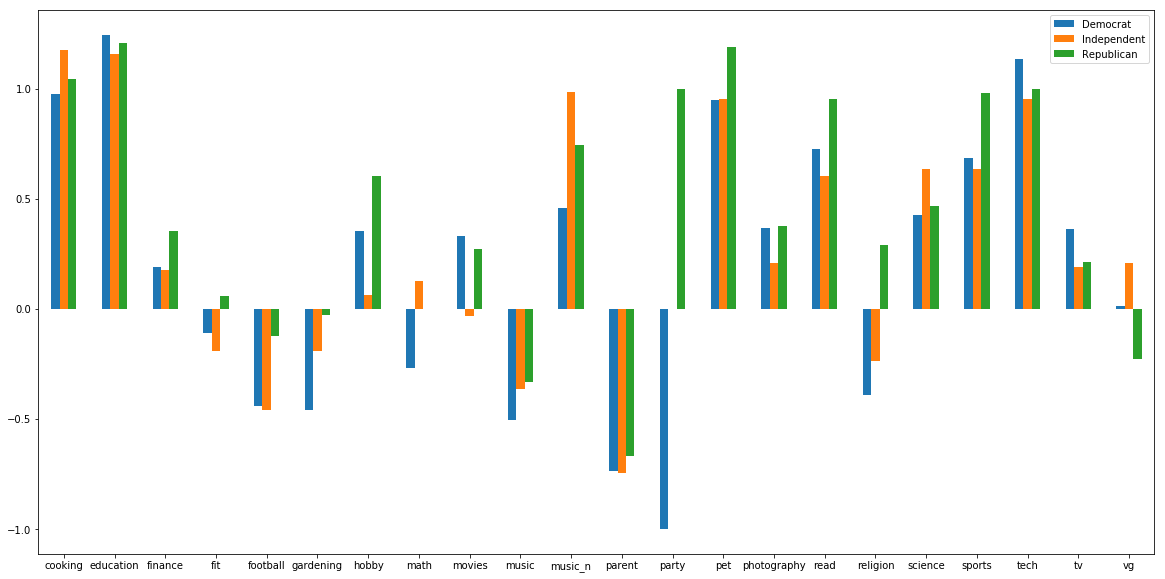

In [644]:
ax = bdf.plot.bar(rot=0,  figsize=(20, 10))

In [680]:
opt = ['fit', 'hobby', 'math', 'music_n', 'religion', 'sports', 'vg']
ni_ys = rddf['party']
ni_xs = rddf[qlist]
X_train, X_test, y_train, y_test = train_test_split(ni_xs, ni_ys, test_size=0.2, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(ni_xs[opt], ni_ys, test_size=0.2, random_state=0)
reg = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
pred = reg.predict(X_test)
tpred = reg.predict(X_train)
print("Accuracy handpicked features:" + str(np.sum(pred == y_test) / len(y_test)))

Accuracy handpicked features:0.6


In [ ]:
txs = X_train[list(np.nonzero((r<14) * 1)[0])]
topics = []
for s in range(1,14):
    temp = itertools.combinations(txs, s)
    for top in temp:
        topics.append(list(top))

In [703]:
X_train, X_test, y_train, y_test = train_test_split(ni_xs, ni_ys, test_size=0.2, random_state=99)
accuracies = [0] * len(topics)
n_states = 1

for state in range(n_states):
    for i in range(len(topics)):
        Xs = X_train[topics[i]]
        X_tr_cv, X_te_cv, y_tr_cv, y_te_cv = train_test_split(Xs, y_train, test_size=0.2, random_state=state)
        reg = LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(X_tr_cv, y_tr_cv)
        pred = reg.predict(X_te_cv)
        #print("Accuracy "+str(d-1)+" features:" + str(np.sum(pred == y_te_cv) / len(y_te_cv)))
        accuracies[i] += np.sum(pred == y_te_cv) / len(y_te_cv)

for i in range(len(topics)):
    accuracies[i] /= n_states
best_set = np.argmax(accuracies)
Xs = X_train[topics[best_set]]
print(topics[best_set])
reg = LogisticRegression(solver='lbfgs',multi_class='multinomial').fit(Xs, y_train)
pred = reg.predict(X_test[topics[best_set]])
print("CV accuracy: " + str(np.sum(pred == y_test) / len(y_test)))

['parent', 'sports', 'tech']
CV accuracy: 0.56


In [685]:
from sklearn import svm
clf = svm.SVC(gamma = 'auto')
clf.fit(X_train[opt], y_train)  
pred = clf.predict(X_test[opt])
print("SVM accuracy: " + str(np.sum(pred == y_test) / len(y_test)))

SVM accuracy: 0.56


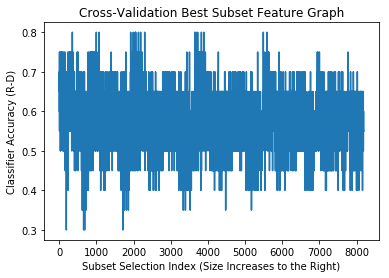

In [708]:
plt.plot(accuracies)
plt.xticks([i for i in range(0, len(topics),1000)])
plt.xlabel("Subset Selection Index (Size Increases to the Right)")
plt.ylabel("Classifier Accuracy (R-D)")
plt.title("Cross-Validation Best Subset Feature Graph")
plt.show()